In [ ]:
#импорт собственных файлов
import data_processing 
import function
#импорт библиотек
import numpy as np
import pandas as pd
#библиотеки для графиков
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#считывание данных

nh3_2rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm.xlsx', sheet_name='Untitled')
no2_2rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_ RH_2%.xlsx', sheet_name='Untitled')
no2_25rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_25%.xlsx', sheet_name='Untitled')
no2_50rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_50%.xlsx', sheet_name='Untitled')
no2_75rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_75%.xlsx', sheet_name='Untitled')

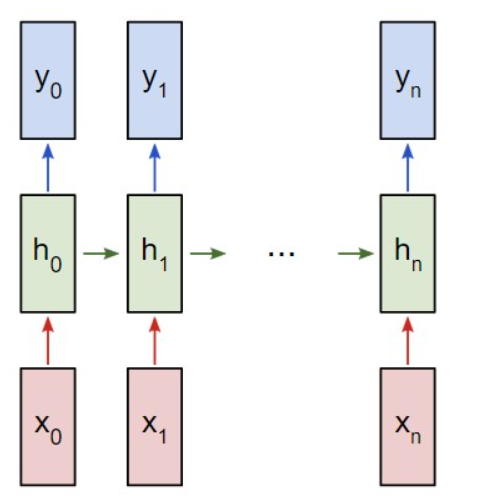

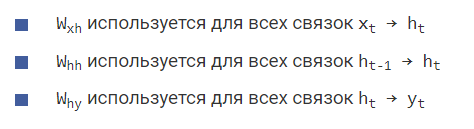

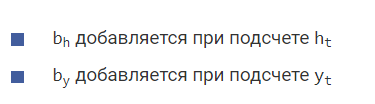

## Для функции forward

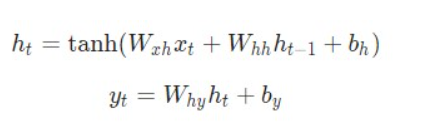

In [ ]:
class MyRNN:
    def __init__(self, input_size, output_size, hidden_size):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        #создание весов
        #создаем матрицу,размером hidden_size и какой-нибудь_size, которые распр по норм закону
        self.Wxh = np.random.randn(hidden_size, input_size)/1000 #пока по примеру делаю, там посмотрим
        self.Whh = np.random.randn(hidden_size, hidden_size)/1000
        self.Why = np.random.randn(output_size, hidden_size)/1000

        #смещения
        #вектора из 0
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
    
    def forward(self, inputs):
        """Прямое распространение"""
        #создадим наш изначальный h
        h = np.zeros((self.Whh.shape[0], 1))# вектор из 0 dim = кол-во строк в Whh

        self.last_inputs = inputs #сохранение последне1 последовательности(исп для backward)
        self.last_hs = { 0: h }# сохранение последнего состояния

        #Теперь будем считать каждый шаг RNN
        for i, x in enumerate(inputs):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            self.last_hs[i+1] = h
        
        #значение y
        y = self.Why @ h + self.by

        return y, h
    
    def backprop(self, dy, learning_rate = 0.02):
        n = len(self.last_inputs) #длина нашей входной последовательности

        dWhy = dy @ self.last_hs[n].T#град функции потерь по весам, соед скрыт и выходной слой 
        dby = dy #градиент по смещению выходного слоя - град по выходу

        # инициализация еще некоторых элементов
        dWhh = np.zeros(self.Whh.shape)
        dWxh = np.zeros(self.Wxh.shape)
        dbh = np.zeros(self.bh.shape)

        # dL/dh для последнего h
        dh = self.Why.T @ dy

        # сама штука для того чтобы идти обратно
        for t in reversed(range(n)):
            # dL/dh * (1 - h^2)
            temp = ((1-self.last_hs[t+1]**2)*dh)

            # dL/db = dL/dh * (1 - h^2)
            dbh+=temp

            #dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
            dWhh+=temp @ self.last_hs[t].T

            # dL/dWxh = dL/dh * (1 - h^2) * x
            dWxh+=temp @ self.last_inputs[t].T

            # След dL/dh = dL/dh * (1 - h^2) * Whh
            dh = self.Whh @ temp

        # Предотвращаем взрыв градиентов
        for d in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(d, -1, 1, out=d)
            
        # обновляем веса используя градиентный спуск
        self.Whh -= learning_rate * dWhh
        self.Wxh -= learning_rate * dWxh
        self.Why -= learning_rate * dWhy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby



In [1]:
import numpy as np

class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Инициализация весов случайными значениями
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01 # input to hidden
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01 # hidden to hidden
        self.Why = np.random.randn(output_size, hidden_size) * 0.01 # hidden to output
        self.bh = np.zeros((hidden_size, 1)) # hidden bias
        self.by = np.zeros((output_size, 1)) # output bias

    def forward(self, inputs):
        """Прямое распространение"""
        h = np.zeros((self.hidden_size, 1)) # Инициализация скрытого состояния
        self.last_inputs = inputs
        self.last_hs = { 0: h }

        for i, x in enumerate(inputs):
            h = np.tanh(np.dot(self.Wxh, x.reshape(-1,1)) + np.dot(self.Whh, h) + self.bh)
            self.last_hs[i + 1] = h

        y = np.dot(self.Why, h) + self.by
        return y

    def backward(self, dY):
        """Обратное распространение"""
        dWhy = np.dot(dY, self.last_hs[len(self.last_inputs)].T)
        dby = dY
        dhnext = np.dot(self.Why.T, dY)

        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dbh = np.zeros_like(self.bh)

        for t in reversed(range(len(self.last_inputs))):
            dh = dhnext
            dhraw = (1 - self.last_hs[t+1] * self.last_hs[t+1]) * dh
            dbh += dhraw
            dWxh += np.dot(dhraw, self.last_inputs[t].reshape(1,-1))
            dWhh += np.dot(dhraw, self.last_hs[t].T)
            dhnext = np.dot(self.Whh.T, dhraw)

        return dWxh, dWhh, dWhy, dbh, dby


    def train(self, inputs, targets, epochs=100, learning_rate=0.1):
        for epoch in range(epochs):
            loss = 0
            for input_seq, target in zip(inputs, targets):
                y = self.forward(input_seq)
                loss += np.sum((y - target)**2) # MSE loss
                dY = 2*(y - target)
                dWxh, dWhh, dWhy, dbh, dby = self.backward(dY)


                self.Wxh -= learning_rate * dWxh
                self.Whh -= learning_rate * dWhh
                self.Why -= learning_rate * dWhy
                self.bh -= learning_rate * dbh
                self.by -= learning_rate * dby
            print(f"Epoch: {epoch}, Loss: {loss}")

# Пример использования (очень упрощенный)
inputs = [np.array([1,0]), np.array([0,1]), np.array([1,1])]
targets = [np.array([0]), np.array([1]), np.array([0])] #Пример XOR

rnn = SimpleRNN(input_size=2, hidden_size=2, output_size=1)
rnn.train(inputs, targets, epochs=1000, learning_rate=0.01)

test_input = [np.array([0,0]), np.array([1,0]), np.array([0,1]), np.array([1,1])]
print(rnn.forward(test_input))

ValueError: shapes (2,2) and (1,1) not aligned: 2 (dim 1) != 1 (dim 0)